# Extended Trapping SINDy - Sparse testing
In "Local stability guarantees for data-driven quadratically nonlinear systems", we did not actually try to produce sparse solution for coefficients of the identified system, $\Xi$. The reason is that in fact we do not know if the system is truly sparse or how sparse it is even if it is truly sparse. We need a theorem or a benchmark to evaluate to what extent we can trust the sparse model discovered by the algorithm.

But before the evaluation, let us find out if the sparse regularizer will destroy our stability guarantees or the stability itself. We should remember that the conservative stability estimates given by the theorem do not reveal the exact long-term stability domain.

We will try to explore this by a few examples.

In [ ]:
import warnings

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import scipy.io # for .mat files

import pysindy as ps
from pysindy.utils import *

# ignore warnings
warnings.filterwarnings("ignore")

# Import useful functions
from trapping_utils import (
    integrator_keywords,
    sindy_library,
    make_fits,
    obj_function,
    check_local_stability,
    make_trap_progress_plots,
)

Start training now without sparse regularization!

# Lorenz

The algorithm works pretty well on nonchaotic systems in general, but what about chaotic systems?

$$
\begin{align}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} &= \begin{bmatrix}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta
    \end{bmatrix}
    \begin{bmatrix}
    x \\
    y \\
    z
    \end{bmatrix}
    +
    \begin{bmatrix}
    0 \\
    -xz \\
    xy
    \end{bmatrix}, \qquad
    \mathbf{A}^S = \begin{bmatrix}
    -\sigma & \frac{1}{2}(\rho+\sigma - m_3) & \frac{1}{2}m_2 \\
    \frac{1}{2}(\rho+\sigma - m_3) & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}.
\end{align}
$$

For Lorenz's choice of parameters, $\sigma = 10$, $\rho = 28$, $\beta  = 8/3$, this system is known to exhibit a stable attractor. For $\mathbf{m} = [0,m_2,\rho+\sigma]$ ($m_1$ does not contribute to $\mathbf{A}^S$ so we set it to zero),

$$
\begin{align}
    \mathbf{A}^S &= \begin{bmatrix}
    -\sigma & 0 & \frac{1}{2}m_2 \\
    0 & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}, \qquad
    \lambda_1 = -1, \qquad \lambda_{\pm} = -\frac{1}{2}\left[\beta+\sigma \mp \sqrt{m_2^2 + (\beta-\sigma)^2}\right],
\end{align}
$$

so that if $\lambda_{\pm} < 0$, then $-2\sqrt{\sigma\beta} < m_2 < 2\sqrt{\sigma\beta}$. 
Our algorithm can successfully identify the optimal $\mathbf{m}$, and can be used to identify the inequality bounds on $m_2$ for stability.

In [ ]:
# define parameters
r = 3
N = int((r ** 2 + 3 * r) / 2.0) + 1

# make training and testing data
dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T

max_iter = 5000
eta = 1.0e3
alpha = 1e20
beta = 1e-10
reg_weight_lam = 0
alpha_m = 0.9 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    method="local",
    _n_tgts=3,
    _include_bias=True,
    reg_weight_lam=reg_weight_lam,
    eta=eta,
    alpha_m=alpha_m,
    max_iter=max_iter,
    gamma=-1,
    alpha=alpha,
    beta=beta,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T

# compute relative Frobenius error in the model coefficients
sigma = 10
rho = 28
beta = 8.0 / 3.0
terms = sindy_library.get_feature_names()
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[1 : r + 1, :] = np.asarray(
    [[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]
).T
Xi_lorenz[terms.index("x0 x2"), 1] = -1
Xi_lorenz[terms.index("x0 x1"), 2] = 1
coef_pred = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
print("Frobenius coefficient error = ", coef_pred)


 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.477e+02 ... 1.273e-01 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
  500 ... 2.477e+02 ... 1.986e-06 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 1000 ... 2.477e+02 ... 6.548e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 1500 ... 2.477e+02 ... 3.914e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 2000 ... 2.477e+02 ... 2.929e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 2500 ... 2.477e+02 ... 2.453e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 3000 ... 2.477e+02 ... 2.190e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 3500 ... 2.477e+02 ... 2.034e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 4000 ... 2.477e+02 ... 1.936e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 4500 ... 2.477e+02 ... 1.872e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
(x0)' = 0.086 1 + -9.861 x0 + 9.935 x1 + -0.013 x2 

In [ ]:
# read another training data from MATLAB
mat_data = scipy.io.loadmat('lorenz_data.mat')
data = mat_data['data']
x_train_mat = data[:, 1:]

# train a new model using this set of data
model_mat = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model_mat.fit(x_train_mat, t=t)
model_mat.print()
Xi_mat = model_mat.coefficients().T

# compute relative Frobenius error in the model coefficients
coef_pred_mat = np.linalg.norm(Xi_lorenz - Xi_mat) / np.linalg.norm(Xi_lorenz)
print("Frobenius coefficient error = ", coef_pred_mat)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 5.035e+02 ... 1.273e-01 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 2000 ... 5.035e+02 ... 4.099e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 4000 ... 5.035e+02 ... 3.131e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 6000 ... 5.035e+02 ... 3.025e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 8000 ... 5.035e+02 ... 3.010e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
(x0)' = 0.007 1 + -9.870 x0 + 9.945 x1 + -0.002 x2 + -0.003 x0 x2
(x1)' = -0.081 1 + 27.769 x0 + -0.925 x1 + 0.010 x2 + -0.993 x0 x2 + -0.001 x1 x2
(x2)' = 0.099 1 + -0.004 x0 + -0.001 x1 + -2.664 x2 + 0.003 x0^2 + 0.993 x0 x1 + 0.001 x1^2


In [16]:
mat_data_0 = scipy.io.loadmat('lorenz_data_0.mat')
data_0 = mat_data_0['data']
x_train_mat_0 = data_0[:, 1:]

# train a new model using this set of data
model_mat_0 = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model_mat_0.fit(x_train_mat, t=t)
model_mat_0.print()
Xi_mat_0 = model_mat_0.coefficients().T

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 5.035e+02 ... 1.273e-01 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
  500 ... 5.035e+02 ... 2.199e-06 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 1000 ... 5.035e+02 ... 7.959e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 1500 ... 5.035e+02 ... 5.141e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 2000 ... 5.035e+02 ... 4.099e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 2500 ... 5.035e+02 ... 3.612e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 3000 ... 5.035e+02 ... 3.356e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 3500 ... 5.035e+02 ... 3.214e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 4000 ... 5.035e+02 ... 3.131e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
 4500 ... 5.035e+02 ... 3.082e-07 ... 0.00e+00 ... 4.93e-21 ... 1.76e-02 ... 5.04e+02
(x0)' = 0.007 1 + -9.870 x0 + 9.945 x1 + -0.002 x2 

In [15]:
print(np.sum(np.abs(Xi)) - np.sum(np.abs(Xi_mat)))

0.26257465095733323


Max deviation from the constraints =  9.304170185033994e-07
optimal m:  [-1.14586735 -0.11857296 37.93634323]
As eigvals:  [-9.97180391 -2.6635494  -0.98111503]
0.5 * |tilde{H}_0|_F =  8.220897582928223e-07
0.5 * |tilde{H}_0|_F^2 / beta =  0.01351663141379902
Estimate of trapping region size, Rm =  103.967300148751
Normalized trapping region size, Reff =  4.39048471913312
Local stability size, R_ls=  1790056.44402147
Frobenius error =  0.7044943688557609
Frobenius coefficient error =  0.013686121195205798
Time-averaged derivative error =  1.287952405202183e-05


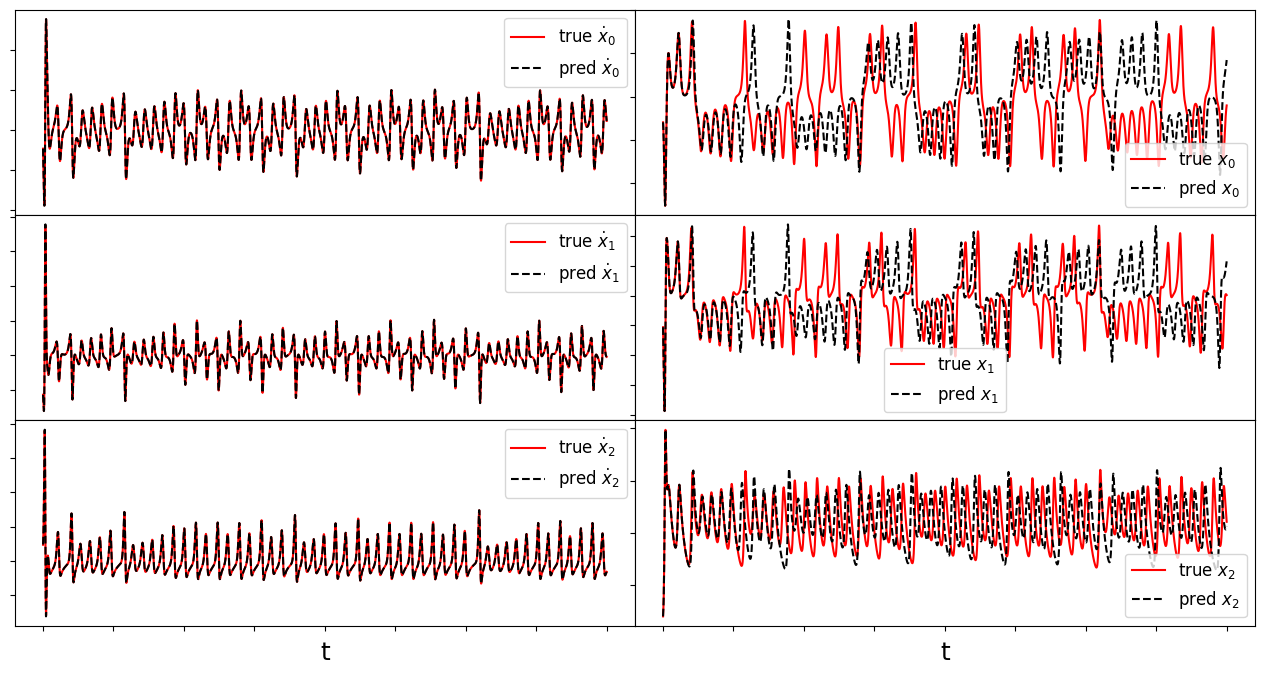

In [14]:
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, "lorenz")

PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print("Max deviation from the constraints = ", Q_sum)

mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val**2))
check_local_stability(Xi, sindy_opt, mean_val)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print("Frobenius error = ", E_pred)

# compute relative Frobenius error in the model coefficients
sigma = 10
rho = 28
beta = 8.0 / 3.0
terms = sindy_library.get_feature_names()
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[1 : r + 1, :] = np.asarray(
    [[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]
).T
Xi_lorenz[terms.index("x0 x2"), 1] = -1
Xi_lorenz[terms.index("x0 x1"), 2] = 1
coef_pred = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
print("Frobenius coefficient error = ", coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(
        xdot_test[i, :] - xdot_test_pred[i, :], xdot_test[i, :] - xdot_test_pred[i, :]
    ) / np.dot(xdot_test[i, :], xdot_test[i, :])
print("Time-averaged derivative error = ", np.nanmean(deriv_error))

In [ ]:
# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')

Let us train again with $\ell_1$ regularizer.

In [ ]:
max_iter = 2000
eta = 1.0e3
alpha = 1e20
beta = 1e-8
threshold = 1e4
alpha_m = 2e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))

In [ ]:
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], 'r-')
ax1.plot(x_train_pred[:, 0], x_train_pred[:, 1], x_train_pred[:, 2], 'k-')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'b')
ax2.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'k--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation + prediction')
fig.show()

Now let's do a sweep.

In [ ]:
thresholds = np.array([0, 10, 100, 1e3, 1e4, 1e5])
deviation = np.zeros(np.size(thresholds))
pred_loss = np.zeros(np.size(thresholds))
coef_error = np.zeros(np.size(thresholds))
r_ls = np.zeros(np.size(thresholds))
l0 = np.zeros(np.size(thresholds))

sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1

for i in range(len(thresholds)):

    max_iter = 2000
    eta = 1.0e5
    alpha = 1e20
    beta = 1e-8
    threshold = 0.1
    alpha_m = 2e-1 * eta

    if thresholds[i] == 0:
        max_iter = 20000

    # run trapping SINDy... no more constraints!
    sindy_opt = ps.TrappingSR3(
        threshold=thresholds[i], eta=eta,
        gamma=-1,
        alpha_m=alpha_m,
        alpha=alpha,
        beta=beta,
        max_iter=max_iter,
        verbose=False,
    )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t)
    model.print()
    Xi = model.coefficients().T
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mean_val = np.mean(x_test_pred, axis=0)
    mean_val = np.sqrt(np.sum(mean_val ** 2))
    rm, r_ls[i] = check_local_stability(r, Xi, sindy_opt, mean_val)
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
    deviation[i] = np.max(np.abs(Q_sum))
    coef_error[i] = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
    pred_loss[i] = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
    nonzero_ind = np.abs(Xi) >= 1e-3
    nonzeros = np.zeros(np.shape(Xi))
    nonzeros[nonzero_ind] = 1
    l0[i] = np.count_nonzero(nonzeros)

Now draw these results!

In [ ]:
nonzero_ind = np.abs(Xi) >= 1e-3
nonzeros = np.zeros(np.shape(Xi))
nonzeros[nonzero_ind] = 1
l0[5] = np.count_nonzero(nonzeros)

fig1 = plt.figure(figsize=(8,4))
plt.plot(thresholds, deviation, label=r"$\epsilon_Q$", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig2 = plt.figure(figsize=(8,4))
plt.plot(thresholds, pred_loss, label=r"prediction loss", linewidth=3)
plt.plot(thresholds, coef_error, label=r"coefficients error", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig3 = plt.figure(figsize=(8,4))
plt.plot(thresholds, r_ls, label=r"local stability radius", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig4 = plt.figure(figsize=(8,4))
plt.plot(thresholds, l0, label=r"$\ell_0$ norm of coefficients", linewidth=3)

plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

In [ ]:
thresholds = np.arange(10, 460, 50)
deviation = np.zeros(np.size(thresholds))
pred_loss = np.zeros(np.size(thresholds))
coef_error = np.zeros(np.size(thresholds))
r_ls = np.zeros(np.size(thresholds))
l0 = np.zeros(np.size(thresholds))

sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1

for i in range(len(thresholds)):

    max_iter = 2000
    eta = 1.0e5
    alpha = 1e20
    beta = 1e-8
    threshold = 0.1
    alpha_m = 2e-1 * eta

    if thresholds[i] == 0:
        max_iter = 20000

    # run trapping SINDy... no more constraints!
    sindy_opt = ps.TrappingSR3(
        threshold=thresholds[i], eta=eta,
        gamma=-1,
        alpha_m=alpha_m,
        alpha=alpha,
        beta=beta,
        max_iter=max_iter,
        verbose=False,
    )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t)
    model.print()
    Xi = model.coefficients().T
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mean_val = np.mean(x_test_pred, axis=0)
    mean_val = np.sqrt(np.sum(mean_val ** 2))
    rm, r_ls[i] = check_local_stability(r, Xi, sindy_opt, mean_val)
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
    deviation[i] = np.max(np.abs(Q_sum))
    coef_error[i] = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
    pred_loss[i] = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
    nonzero_ind = np.abs(Xi) >= 1e-3
    nonzeros = np.zeros(np.shape(Xi))
    nonzeros[nonzero_ind] = 1
    l0[i] = np.count_nonzero(nonzeros)

In [ ]:
nonzero_ind = np.abs(Xi) >= 1e-3
nonzeros = np.zeros(np.shape(Xi))
nonzeros[nonzero_ind] = 1
l0[5] = np.count_nonzero(nonzeros)

fig1 = plt.figure(figsize=(8,4))
plt.plot(thresholds, deviation, label=r"$\epsilon_Q$", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig2 = plt.figure(figsize=(8,4))
plt.plot(thresholds, pred_loss, label=r"prediction loss", linewidth=3)
plt.plot(thresholds, coef_error, label=r"coefficients error", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig3 = plt.figure(figsize=(8,4))
plt.plot(thresholds, r_ls, label=r"local stability radius", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig4 = plt.figure(figsize=(8,4))
plt.plot(thresholds, l0, label=r"$\ell_0$ norm of coefficients", linewidth=3)

plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

## We also want to introduce the ZSINDy method to build in sparsity to the trapping models.

ZSindy is a recent strategy to directly construct sparse dynamical models without applying the traditional sparse regularization. Based on Bayesian inference, ZSindy leverages sparse priors and the fact that for most physical systems, only a few relative terms determine the dynamics so to combine SINDy with Bayesian approach to achieve the parsimonious representation of dynamical systems.

An early-stage work at present is to compute the free energy of each trapping model.

In [3]:
# some useful tools
from z_utils import *

In [4]:
def sparse_penalty_fe(Fs, lmbda, num_terms):
        """
        Applies a sparse penalty to the given feature matrix.

        Parameters:
        - Fs (numpy.ndarray): The feature matrix.
        - lmbda (float): The sparse penalty parameter.
        - num_terms (int): The number of terms in the penalty.

        Returns:
        - numpy.ndarray: The feature matrix with the sparse penalty applied.
        """
        return Fs + lmbda * num_terms

def normalize_lambda_numdata(Lambda, rho, N):
    return Lambda * N * rho**2

### Compute the free energy for trapping SINDy model of Lorenz 1963.

In [5]:
# define parameters
r = 3
N = int((r**2 + 3 * r) / 2.0) + 1

# make training and testing data
dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
max_iter = 5000
eta = 1.0e3
alpha = 1e20
beta = 1e-10
reg_weight_lam = 0
alpha_m = 0.9 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    method="local",
    _n_tgts=3,
    _include_bias=True,
    reg_weight_lam=reg_weight_lam,
    eta=eta,
    alpha_m=alpha_m,
    max_iter=max_iter,
    gamma=-1,
    alpha=alpha,
    beta=beta,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
# xdot_test = model.differentiate(x_test, t=t)
# xdot_test_pred = model.predict(x_test)
# x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
# x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

Theta = model.feature_library.transform(x_train)
xdot = model.differentiate(x_train, t=t)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.477e+02 ... 1.273e-01 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
  500 ... 2.477e+02 ... 1.986e-06 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 1000 ... 2.477e+02 ... 6.548e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 1500 ... 2.477e+02 ... 3.914e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 2000 ... 2.477e+02 ... 2.929e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 2500 ... 2.477e+02 ... 2.453e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 3000 ... 2.477e+02 ... 2.190e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 3500 ... 2.477e+02 ... 2.034e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 4000 ... 2.477e+02 ... 1.936e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 4500 ... 2.477e+02 ... 1.872e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
(x0)' = 0.086 1 + -9.861 x0 + 9.935 x1 + -0.013 x2 

In [33]:
# print("Xi = ", Xi)
C = Theta.T @ Theta
V = Theta.T @ xdot

num_feats = Theta.shape[1]
print("We have {} features".format(num_feats))
feat_names = sindy_library.get_feature_names()
temp_name = []
for a in feat_names:
    temp_name.append(''.join(a.split()))
feat_names = temp_name
print(list(feat_names))
gammas_3, Fs_3, mean_coefs_3 = free_energy_coefs(C, V, .1, 3, num_feats, 0)
Fs_list_3, coef_list_3 = dict_to_lists(Fs_3, mean_coefs_3, gammas_3)

We have 10 features
['1', 'x0', 'x1', 'x2', 'x0^2', 'x0x1', 'x0x2', 'x1^2', 'x1x2', 'x2^2']


Compare the accuracy, but before the penalty.

In [68]:
Fs_list_3 = np.array(Fs_list_3).reshape(-1)
id = np.argsort(Fs_list_3)
sorted_Fs_3 = [Fs_list_3[i] for i in id]
print(gammas_3)
sorted_gammas_3 = []
sorted_gammas_3 = [gammas_3[i] for i in id]
sorted_coefs_3 = [coef_list_3[i] for i in id]
print(sorted_Fs_3[0], sorted_gammas_3[0], sorted_coefs_3[0])
print(Xi[:3,0])
print(coef_list_3)

[(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 3, 9), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0, 4, 8), (0, 4, 9), (0, 5, 6), (0, 5, 7), (0, 5, 8), (0, 5, 9), (0, 6, 7), (0, 6, 8), (0, 6, 9), (0, 7, 8), (0, 7, 9), (0, 8, 9), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 2, 8), (1, 2, 9), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 3, 7), (1, 3, 8), (1, 3, 9), (1, 4, 5), (1, 4, 6), (1, 4, 7), (1, 4, 8), (1, 4, 9), (1, 5, 6), (1, 5, 7), (1, 5, 8), (1, 5, 9), (1, 6, 7), (1, 6, 8), (1, 6, 9), (1, 7, 8), (1, 7, 9), (1, 8, 9), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 3, 9), (2, 4, 5), (2, 4, 6), (2, 4, 7), (2, 4, 8), (2, 4, 9), (2, 5, 6), (2, 5, 7), (2, 5, 8), (2, 5, 9), (2, 6, 7), (2, 6, 8), (2, 6, 9), (2, 7, 8), (2, 7, 9), (2, 8, 9), (3, 4, 5), (3, 4, 6), (3, 4, 7), (3, 4, 8), (3, 4, 9), (3, 5, 6)

Add suitable sparse penalty.

In [71]:
lmbda = normalize_lambda_numdata(1e5, .1, xdot.shape[0])
Fe_3 = sparse_penalty_fe(np.array(Fs_list_3), lmbda, 3)
idd = np.argsort(Fe_3)
sorted_Fe_3 = [Fe_3[i] for i in id]
print(gammas_3)
sorted_gammas_3 = []
sorted_gammas_3 = [gammas_3[i] for i in idd]
sorted_coefs_3 = [coef_list_3[i] for i in idd]
print(sorted_Fe_3[0], sorted_gammas_3[0], sorted_coefs_3[0])
print(Xi[:3,0])

[(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 3, 9), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0, 4, 8), (0, 4, 9), (0, 5, 6), (0, 5, 7), (0, 5, 8), (0, 5, 9), (0, 6, 7), (0, 6, 8), (0, 6, 9), (0, 7, 8), (0, 7, 9), (0, 8, 9), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 2, 8), (1, 2, 9), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 3, 7), (1, 3, 8), (1, 3, 9), (1, 4, 5), (1, 4, 6), (1, 4, 7), (1, 4, 8), (1, 4, 9), (1, 5, 6), (1, 5, 7), (1, 5, 8), (1, 5, 9), (1, 6, 7), (1, 6, 8), (1, 6, 9), (1, 7, 8), (1, 7, 9), (1, 8, 9), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 3, 9), (2, 4, 5), (2, 4, 6), (2, 4, 7), (2, 4, 8), (2, 4, 9), (2, 5, 6), (2, 5, 7), (2, 5, 8), (2, 5, 9), (2, 6, 7), (2, 6, 8), (2, 6, 9), (2, 7, 8), (2, 7, 9), (2, 8, 9), (3, 4, 5), (3, 4, 6), (3, 4, 7), (3, 4, 8), (3, 4, 9), (3, 5, 6)

Now plot these free energies vs. coefficients combinations.

-357995034.89424485
(0, 1, 2)


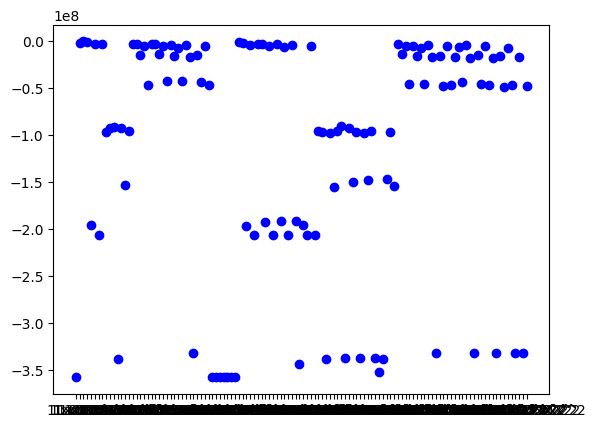

In [68]:
myList = sorted(Fs_3.items())
x, y = zip(*myList)
y = np.array(y).reshape(-1)

comb = []
for i in range(len(x)):
    a = list(x[i])
    c_temp = []
    for c in a:
        c_temp.append(feat_names[c])
    comb.append(' '.join(c_temp))
print(y[0])
print(x[0])
plt.scatter(comb, y, color='blue', marker='o', label='Free Energies')

In [72]:
def lowest_n_combs(num_lowest, Fs, feat_names):
    """
    Calculate the lowest energies of given number of combinations.

    Parameters:


    Returns:

    """
    myList = sorted(Fs.items())
    x, y = zip(*myList)
    y = np.array(y).reshape(-1)
    lowest_n = np.argsort(y)[:num_lowest]

    Fs_n = []
    combs_n = []
    for i in range(num_lowest):
        a = list(x[lowest_n[i]])
        c_temp = []
        for c in a:
            c_temp.append(feat_names[c])
        combs_n.append(' '.join(c_temp))
        Fs_n.append(lowest_n[i])

    lowest_n = np.argsort(y)[:num_lowest]
    comb_n = []
    Fs_n = []
    for i in range(len(lowest_n)):
        comb_n.append(comb_n[lowest_n[i]])
        Fs_n.append(lowest_n[i])

    return comb_n, Fs_n

We can print the lowest 5 combinations.

[-357995273.2474563, -357995042.10258603, -357995037.27177244, -357995034.89424485, -357995031.76366246]
['x0 x1 x1x2', 'x0 x1 x1^2', 'x0 x1 x0x1', '1 x0 x1', 'x0 x1 x2']


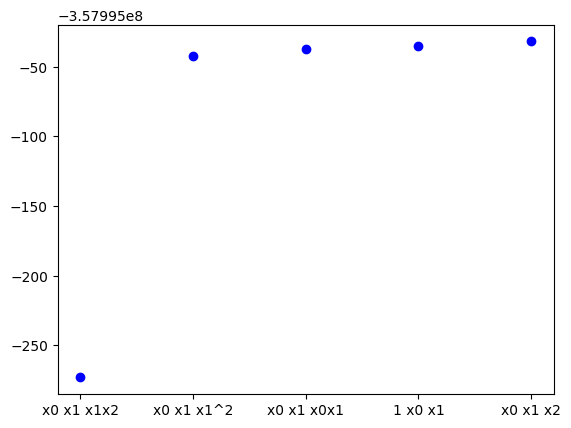

In [67]:
lowest5 = np.argsort(np.array(y).reshape(-1))[:5]
comb5 = []
Fs5 = []
for i in range(len(lowest5)):
    comb5.append(comb[lowest5[i]])
    Fs5.append(y[lowest5[i]])

print(Fs5)
print(comb5)
plt.scatter(comb5, Fs5, color='blue', marker='o')

Repeat again for the set of subsets of $P(\Xi)$ containing 2 elements.

In [89]:
gammas_2, Fs_2, mean_coefs_2 = free_energy_coefs(C, V, .1, 2, num_feats, 0)
myList_2 = sorted(Fs_2.items())
x_2, y_2 = zip(*myList_2)
Fs_list_2, coef_list_2 = dict_to_lists(Fs_2, mean_coefs_2, gammas_2)
Fs_list_2 = np.array(Fs_list_2).reshape(-1)
id_2 = np.argsort(Fs_list_2)
sorted_coefs_2 = []
sorted_coefs_2 = [coef_list_2[i] for i in id_2]
sorted_gammas_2 = [gammas_2[i] for i in id_2]
print(sorted_coefs_2[0], sorted_gammas_2[0])
print([feat_names[i] for i in sorted_gammas_2[0]])

comb_2 = []
for i in range(len(x_2)):
    a = list(x_2[i])
    c_temp = []
    for c in a:
        c_temp.append(feat_names[c])
    comb_2.append(' '.join(c_temp))

[ 0.02508245 -0.02502511] (1, 2)
['x0', 'x1']


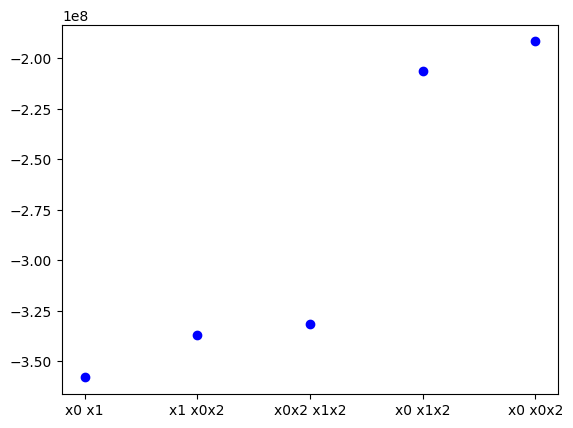

In [41]:
lowest5_2 = np.argsort(np.array(y_2).reshape(-1))[:5]
comb5_2 = []
Fs5_2 = []
for i in range(len(lowest5_2)):
    comb5_2.append(comb_2[lowest5_2[i]])
    Fs5_2.append(y_2[lowest5_2[i]])

plt.scatter(comb5_2, Fs5_2, color='blue', marker='o')

Consider all features?

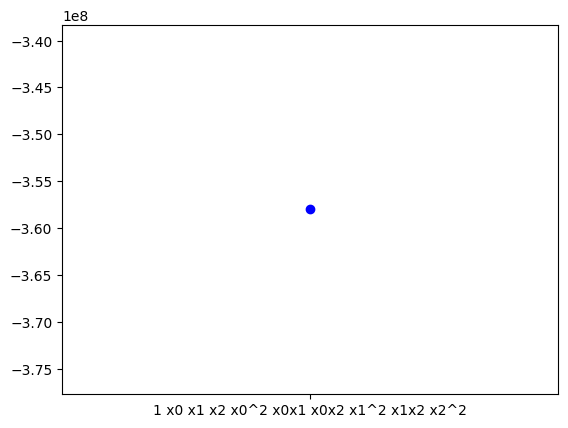

In [42]:
gammas_all, Fs_all, mean_coefs_all = free_energy_coefs(C, V, .1, num_feats, num_feats, 0)
myList_all = sorted(Fs_all.items())
x_all, y_all = zip(*myList_all)

comb_none = []
for i in range(len(x_all)):
    a = list(x_all[i])
    c_temp = []
    for c in a:
        c_temp.append(feat_names[c])
    comb_none.append(' '.join(c_temp))
plt.scatter(comb_none, np.array(y_all), color='blue', marker='o', label='Free Energies')

Do a sweep for all size of the $\gamma$

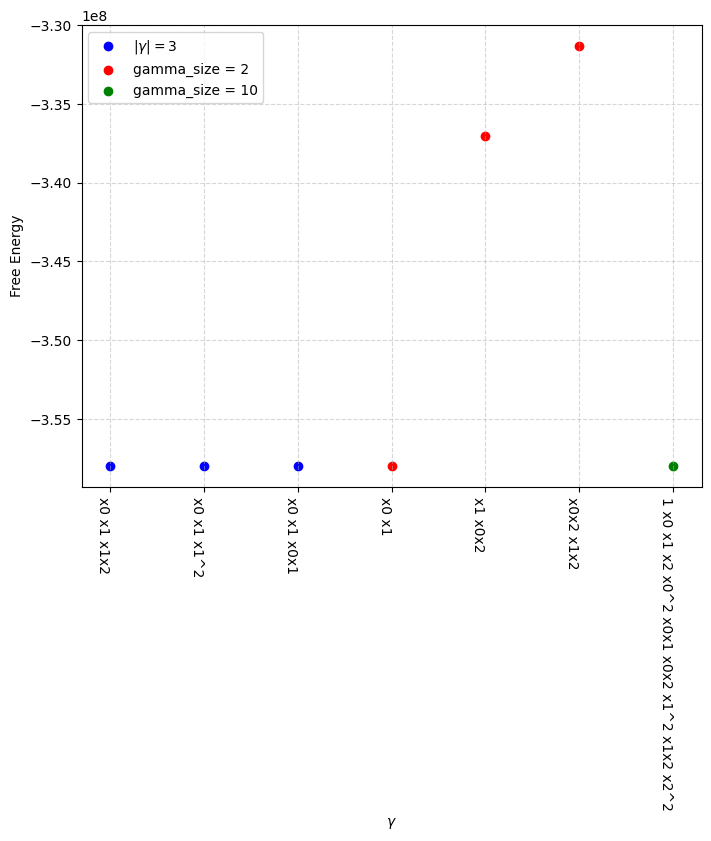

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.xticks(rotation=-90, ha='right')

# Plot lowest 5 combinations of 2, 3 and all 10 coefficients together
scatter1 = ax.scatter(comb5[:3], Fs5[:3], color='blue', marker='o', label=r'$|\gamma| = 3$')
scatter2 = ax.scatter(comb5_2[:3], Fs5_2[:3], color='red', marker='o', label=r'$|\gamma| = 2$')
scatter3 = ax.scatter(comb_none, np.array(y_all), color='green', marker='o', label=r'$|\gamma| = 10$')

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Free Energy')
ax.legend()
ax.grid(True, linestyle='--', alpha = .5)
plt.show()

Add sparse penalties would make some difference.

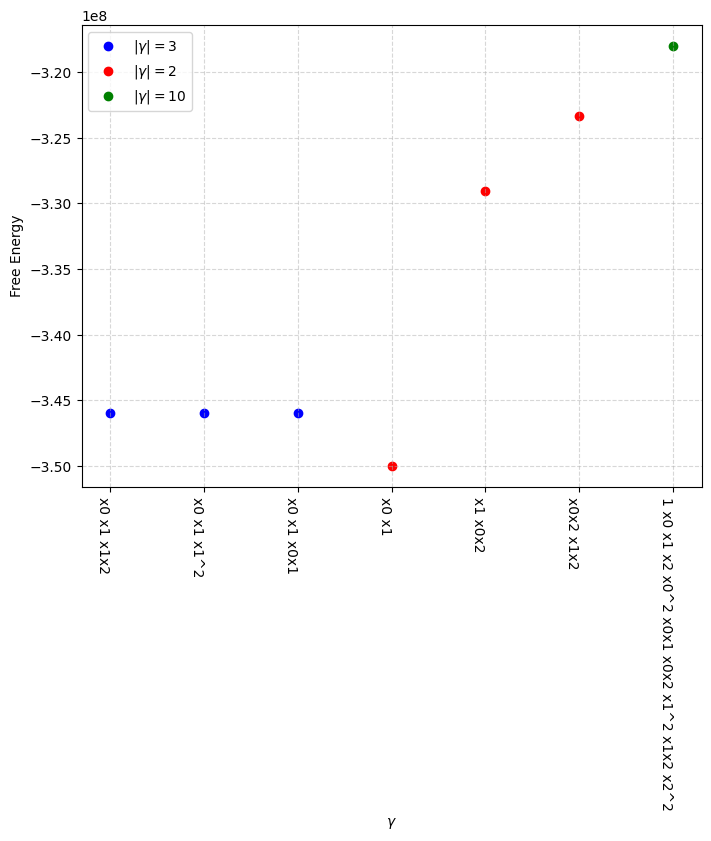

In [76]:
lmbda = normalize_lambda_numdata(1e5, .1, xdot.shape[0])
fe_3 = sparse_penalty_fe(np.array(Fs5), lmbda, 3)
fe_2 = sparse_penalty_fe(np.array(Fs5_2), lmbda, 2)
fe_10 = sparse_penalty_fe(np.array(y_all), lmbda, 10)

fig2, ax2 = plt.subplots(figsize = (8, 6))
plt.xticks(rotation=-90, ha='right')

# Plot lowest 5 combinations of 2, 3 and all 10 coefficients together
scatter1 = ax2.scatter(comb5[:3], fe_3[:3], color='blue', marker='o', label=r'$|\gamma| = 3$')
scatter2 = ax2.scatter(comb5_2[:3], fe_2[:3], color='red', marker='o', label=r'$|\gamma| = 2$')
scatter3 = ax2.scatter(comb_none, fe_10, color='green', marker='o', label=r'$|\gamma| = 10$')

ax2.set_xlabel(r'$\gamma$')
ax2.set_ylabel('Free Energy')
ax2.legend()
ax2.grid(True, linestyle='--', alpha = .5)
plt.show()

# Mean field model

$$
    \frac{d}{dt}\begin{bmatrix}x \\ y \\z \end{bmatrix} = \begin{bmatrix} \mu & -1 & 0 \\1 & \mu & 0 \\ 0 & 0 & -1 \\ \end{bmatrix}
    \begin{bmatrix} x \\ y \\z \end{bmatrix}
    + \begin{bmatrix}- xz \\ - yz \\ x^2 + y^2\end{bmatrix} = \mathbf{L}\mathbf{x} + \mathbf{Q}\mathbf{xx},
$$
where $\mathbf{L}$ and $\mathbf{Q}$ denote the linear and quadratic parts of the model, respectively.

In [93]:
# define parameters
r = 3
mu = 1e-2
dt = 0.01
T = 500
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = rng.random((3,)) - 0.5
x_train = solve_ivp(
    meanfield, t_span, x0, t_eval=t, args=(mu,), **integrator_keywords
).y.T
x0 = (mu, mu, 0)
x_test = solve_ivp(
    meanfield, t_span, x0, t_eval=t, args=(mu,), **integrator_keywords
).y.T

# define hyperparameters
reg_weight_lam = 0.0
eta = 1e5
max_iter = 5000


# run trapping SINDy algorithm
sindy_opt = ps.TrappingSR3(
    _n_tgts=3,
    _include_bias=True,
    reg_weight_lam=reg_weight_lam,
    eta=eta,
    max_iter=max_iter,
    gamma=-1,
    verbose=True,
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T


 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 3.181e-08 ... 9.461e-05 ... 0.00e+00 ... 1.50e-20 ... 1.36e-46 ... 9.46e-05
  500 ... 2.055e-10 ... 3.027e-07 ... 0.00e+00 ... 1.50e-20 ... 4.55e-47 ... 3.03e-07
 1000 ... 1.990e-10 ... 5.792e-08 ... 0.00e+00 ... 1.50e-20 ... 4.52e-47 ... 5.81e-08
 1500 ... 1.975e-10 ... 2.079e-08 ... 0.00e+00 ... 1.50e-20 ... 6.82e-47 ... 2.10e-08
 2000 ... 1.970e-10 ... 1.014e-08 ... 0.00e+00 ... 1.50e-20 ... 2.21e-47 ... 1.03e-08
 2500 ... 1.969e-10 ... 5.875e-09 ... 0.00e+00 ... 1.50e-20 ... 7.68e-48 ... 6.07e-09
 3000 ... 1.968e-10 ... 3.793e-09 ... 0.00e+00 ... 1.50e-20 ... 2.75e-47 ... 3.99e-09
 3500 ... 1.967e-10 ... 2.635e-09 ... 0.00e+00 ... 1.50e-20 ... 1.39e-46 ... 2.83e-09
 4000 ... 1.967e-10 ... 1.931e-09 ... 0.00e+00 ... 1.50e-20 ... 1.24e-46 ... 2.13e-09
 4500 ... 1.967e-10 ... 1.472e-09 ... 0.00e+00 ... 1.50e-20 ... 5.63e-47 ... 1.67e-09
(x0)' = 0.010 x0 + -1.000 x1 + -1.000 x0 x2
(x1)' =

In [94]:
rng = np.random.default_rng(1)

For Atmospheric oscillator from Tuwankotta et al and Trapping SINDy paper

In [95]:
# define parameters
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps * k1
mu2 = -eps * k2
alpha = -2.0
omega = 3.0

# Make training and testing data
dt = 0.01
T = 100
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = rng.random((3,)) - 0.5
x_train = solve_ivp(
    oscillator,
    t_span,
    x0,
    t_eval=t,
    args=(mu1, mu2, omega, alpha, beta, sigma),
    **integrator_keywords
).y.T
x0 = rng.random((3,)) - 0.5
x_test = solve_ivp(
    oscillator,
    t_span,
    x0,
    t_eval=t,
    args=(mu1, mu2, omega, alpha, beta, sigma),
    **integrator_keywords
).y.T

# define hyperparameters
eta = 1.0e8

# run trapping SINDy, reusing previous reg_weight_lam, max_iter and constraints
sindy_opt = ps.TrappingSR3(
    _n_tgts=3,
    _include_bias=True,
    reg_weight_lam=reg_weight_lam,
    eta=eta,
    max_iter=max_iter,
    verbose=True
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 3.213e-04 ... 2.001e-07 ... 0.00e+00 ... 2.26e-19 ... 9.93e-50 ... 3.21e-04
  500 ... 3.213e-04 ... 2.947e-10 ... 0.00e+00 ... 2.26e-19 ... 4.85e-50 ... 3.21e-04
 1000 ... 3.213e-04 ... 1.632e-10 ... 0.00e+00 ... 2.26e-19 ... 9.11e-50 ... 3.21e-04
 1500 ... 3.213e-04 ... 1.147e-10 ... 0.00e+00 ... 2.26e-19 ... 8.74e-50 ... 3.21e-04
 2000 ... 3.213e-04 ... 8.962e-11 ... 0.00e+00 ... 2.26e-19 ... 2.47e-49 ... 3.21e-04
 2500 ... 3.213e-04 ... 7.477e-11 ... 0.00e+00 ... 2.26e-19 ... 1.17e-49 ... 3.21e-04
 3000 ... 3.213e-04 ... 6.526e-11 ... 0.00e+00 ... 2.26e-19 ... 1.28e-49 ... 3.21e-04
 3500 ... 3.213e-04 ... 5.883e-11 ... 0.00e+00 ... 2.26e-19 ... 6.67e-50 ... 3.21e-04
 4000 ... 3.213e-04 ... 5.430e-11 ... 0.00e+00 ... 2.26e-19 ... 1.07e-49 ... 3.21e-04
 4500 ... 3.213e-04 ... 5.103e-11 ... 0.00e+00 ... 2.26e-19 ... 6.22e-50 ... 3.21e-04
(x0)' = 0.050 x0 + 1.100 x0 x1
(x1)' = -0.010 x1 + 

Can ZSindy find the best combination as trapping already did?

In [98]:
Theta = model.feature_library.transform(x_train)
xdot = model.differentiate(x_train, t=t)

# print("Xi = ", Xi)
C_ = Theta.T @ Theta
V_ = Theta.T @ xdot

gammas_2, Fs_2, mean_coefs_2 = free_energy_coefs(C_, V_, .1, 2, num_feats, 0)
myList_2 = sorted(Fs_2.items())
x_2, y_2 = zip(*myList_2)
Fs_list_2, coef_list_2 = dict_to_lists(Fs_2, mean_coefs_2, gammas_2)
Fs_list_2 = np.array(Fs_list_2).reshape(-1)
id_2 = np.argsort(Fs_list_2)
sorted_coefs_2 = []
sorted_coefs_2 = [coef_list_2[i] for i in id_2]
sorted_gammas_2 = [gammas_2[i] for i in id_2]
print(sorted_coefs_2[0], sorted_gammas_2[0])
print([feat_names[i] for i in sorted_gammas_2[0]])

[nan nan] (0, 1)
['1', 'x0']
